1. Data Loading (5 Marks)


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('insurance.csv')

display(df.head(10))
print(f"Shape: {df.shape}")
df.info()
display(df.describe())

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


Shape: (1338, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


2. Data Preprocessing (10 Marks)


In [15]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy import stats

data = df.copy()

# Step 1: Handling Missing Values
print("Missing values:\n", data.isnull().sum())
for col in data.columns:
    if data[col].isnull().sum() > 0:
        if data[col].dtype in ['int64', 'float64']:
            data[col].fillna(data[col].median(), inplace=True)
        else:
            data[col].fillna(data[col].mode()[0], inplace=True)

# Step 2: Outlier Detection (IQR Method)
numerical_cols = ['age', 'bmi', 'children', 'charges']

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers), lower_bound, upper_bound

print("\nOutlier Detection (IQR):")
for col in numerical_cols:
    outlier_count, lb, ub = detect_outliers_iqr(data, col)
    print(f"  {col}: {outlier_count} outliers")

# Step 3: Feature Engineering
def bmi_category(bmi):
    if bmi < 18.5: return 'Underweight'
    elif bmi < 25: return 'Normal'
    elif bmi < 30: return 'Overweight'
    else: return 'Obese'

def age_group(age):
    if age < 30: return 'Young'
    elif age < 50: return 'Middle'
    else: return 'Senior'

data['bmi_category'] = data['bmi'].apply(bmi_category)
data['age_group'] = data['age'].apply(age_group)
data['smoker_bmi'] = data['bmi'] * data['smoker'].apply(lambda x: 1 if x == 'yes' else 0)

# Step 4: Encoding Categorical Variables
label_encoder = LabelEncoder()
data['sex_encoded'] = label_encoder.fit_transform(data['sex'])
data['smoker_encoded'] = label_encoder.fit_transform(data['smoker'])
data = pd.get_dummies(data, columns=['region', 'bmi_category', 'age_group'], drop_first=True)

# Step 5: Feature Scaling
cols_to_drop = ['sex', 'smoker', 'charges']
X = data.drop(cols_to_drop, axis=1)
y = data['charges']

numerical_features = ['age', 'bmi', 'children', 'smoker_bmi']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining: {X_train.shape[0]}, Testing: {X_test.shape[0]}, Features: {X_train.shape[1]}")

Missing values:
 age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

Outlier Detection (IQR):
  age: 0 outliers
  bmi: 9 outliers
  children: 0 outliers
  charges: 139 outliers

Training: 1070, Testing: 268, Features: 14


3. Pipeline Creation (10 Marks)

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

df_pipeline = pd.read_csv('insurance.csv')
X_raw = df_pipeline.drop('charges', axis=1)
y_raw = df_pipeline['charges']

numerical_features_raw = ['age', 'bmi', 'children']
categorical_features_raw = ['sex', 'smoker', 'region']

numerical_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_features_raw),
    ('cat', categorical_transformer, categorical_features_raw)
])

ml_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

print(ml_pipeline)

X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
print(f"\nTraining: {len(X_train_raw)}, Testing: {len(X_test_raw)}")

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['sex', 'smoker',
                                                   'region'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

Training: 1070, Te

4. Primary Model Selection (5 Marks)

In [17]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

print("Model Comparison (R² scores):")
for name, model in models.items():
    temp_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])
    scores = cross_val_score(temp_pipeline, X_train_raw, y_train_raw, cv=5, scoring='r2')
    print(f"  {name:25s}: R² = {scores.mean():.4f} (±{scores.std():.4f})")

print("\nSelected: Random Forest Regressor")
print("Justification: Handles non-linearity, robust to outliers, provides feature importance")

primary_model = RandomForestRegressor(n_estimators=100, random_state=42)

Model Comparison (R² scores):
  Linear Regression        : R² = 0.7331 (±0.0489)
  Ridge Regression         : R² = 0.7332 (±0.0485)
  Decision Tree            : R² = 0.6727 (±0.0718)
  Random Forest            : R² = 0.8245 (±0.0410)
  Gradient Boosting        : R² = 0.8410 (±0.0438)

Selected: Random Forest Regressor
Justification: Handles non-linearity, robust to outliers, provides feature importance


5. Model Training (10 Marks)

Training Time: 0.37s
R²: 0.9742
RMSE: $1,931.37
MAE: $1,060.77


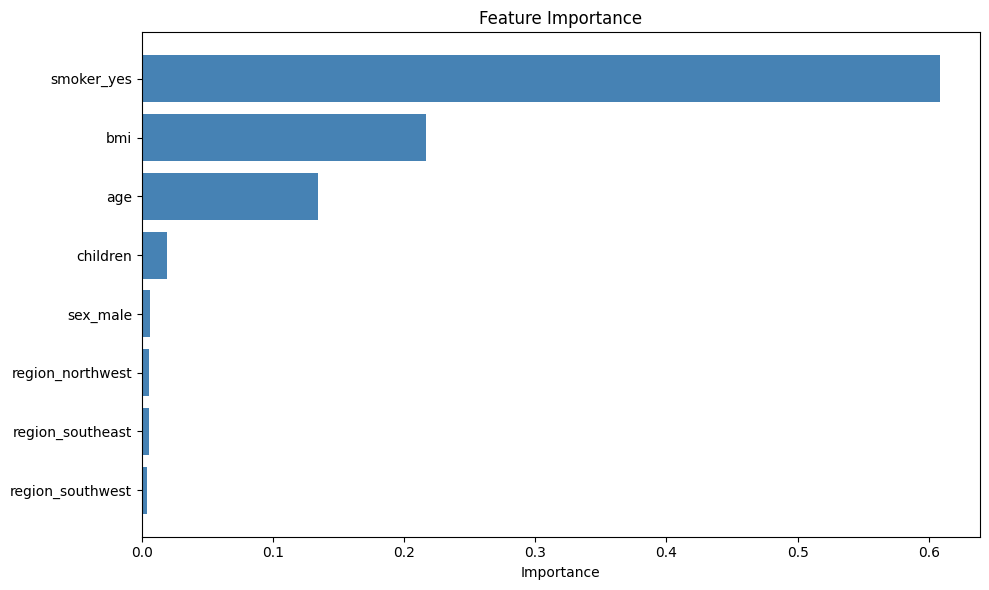

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

training_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

start_time = time.time()
training_pipeline.fit(X_train_raw, y_train_raw)
print(f"Training Time: {time.time() - start_time:.2f}s")

y_train_pred = training_pipeline.predict(X_train_raw)
print(f"R²: {r2_score(y_train_raw, y_train_pred):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_train_raw, y_train_pred)):,.2f}")
print(f"MAE: ${mean_absolute_error(y_train_raw, y_train_pred):,.2f}")

feature_names = numerical_features_raw + list(training_pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features_raw))
importances = training_pipeline.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: feature_importance.png")

6. Cross-Validation (10 Marks)

R² Score: 0.8293 (±0.0389)
RMSE: $4,909.00 (±$434.62)
MAE: $2,749.86 (±$162.23)


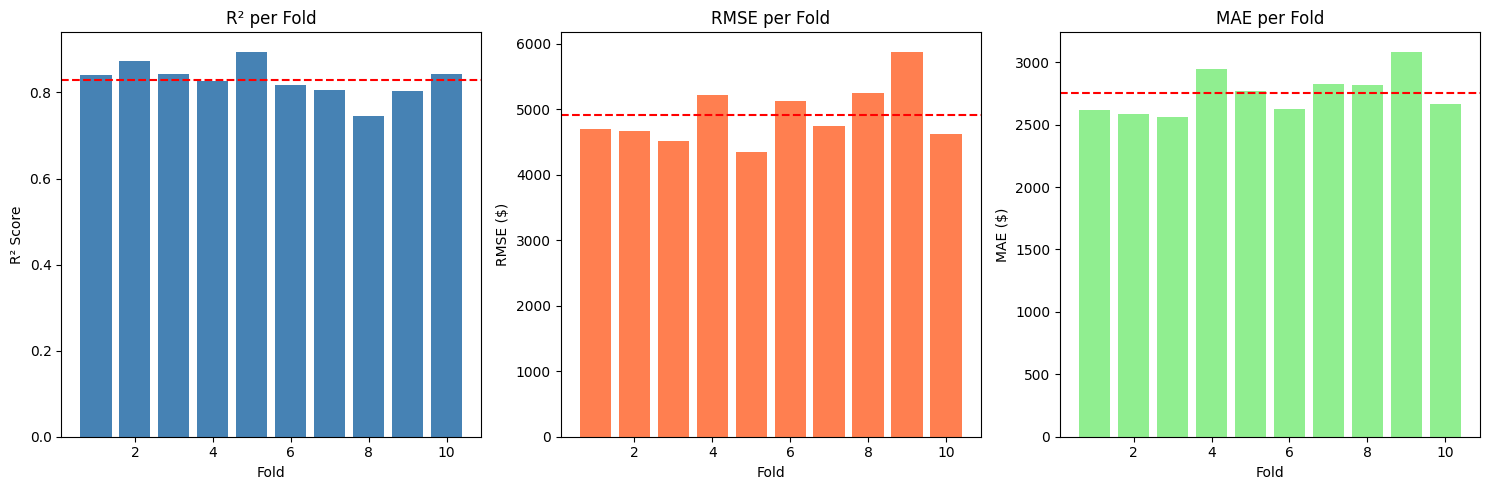

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

cv_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

r2_scores = cross_val_score(cv_pipeline, X_raw, y_raw, cv=kf, scoring='r2')
mse_scores = -cross_val_score(cv_pipeline, X_raw, y_raw, cv=kf, scoring='neg_mean_squared_error')
mae_scores = -cross_val_score(cv_pipeline, X_raw, y_raw, cv=kf, scoring='neg_mean_absolute_error')
rmse_scores = np.sqrt(mse_scores)

print(f"R² Score: {r2_scores.mean():.4f} (±{r2_scores.std():.4f})")
print(f"RMSE: ${rmse_scores.mean():,.2f} (±${rmse_scores.std():,.2f})")
print(f"MAE: ${mae_scores.mean():,.2f} (±${mae_scores.std():,.2f})")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].bar(range(1, k_folds + 1), r2_scores, color='steelblue')
axes[0].axhline(y=r2_scores.mean(), color='red', linestyle='--')
axes[0].set_xlabel('Fold'); axes[0].set_ylabel('R² Score'); axes[0].set_title('R² per Fold')

axes[1].bar(range(1, k_folds + 1), rmse_scores, color='coral')
axes[1].axhline(y=rmse_scores.mean(), color='red', linestyle='--')
axes[1].set_xlabel('Fold'); axes[1].set_ylabel('RMSE ($)'); axes[1].set_title('RMSE per Fold')

axes[2].bar(range(1, k_folds + 1), mae_scores, color='lightgreen')
axes[2].axhline(y=mae_scores.mean(), color='red', linestyle='--')
axes[2].set_xlabel('Fold'); axes[2].set_ylabel('MAE ($)'); axes[2].set_title('MAE per Fold')
plt.tight_layout()
plt.savefig('cross_validation.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: cross_validation.png")

7. Hyperparameter Tuning (10 Marks)

In [20]:
from sklearn.model_selection import RandomizedSearchCV

tuning_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(tuning_pipeline, param_distributions=param_grid, n_iter=50, cv=5, scoring='r2', random_state=42, n_jobs=-1, verbose=1)
random_search.fit(X_train_raw, y_train_raw)

results_df = pd.DataFrame(random_search.cv_results_).sort_values('rank_test_score')
print("\nTop 5 Combinations:")
print(results_df[['rank_test_score', 'mean_test_score', 'std_test_score']].head())

print(f"\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param.replace('regressor__', '')}: {value}")
print(f"\nBest CV R² Score: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits

Top 5 Combinations:
    rank_test_score  mean_test_score  std_test_score
27                1         0.839892        0.041968
25                2         0.839869        0.041684
29                3         0.839719        0.041626
20                4         0.838818        0.042373
17                5         0.837826        0.039210

Best Parameters:
  n_estimators: 50
  min_samples_split: 10
  min_samples_leaf: 4
  max_features: None
  max_depth: None

Best CV R² Score: 0.8399


8. Best Model Selection (10 Marks)

In [21]:
import joblib

best_model = random_search.best_estimator_

print("Best Model Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param.replace('regressor__', '')}: {value}")

default_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])
default_mean = cross_val_score(default_pipeline, X_train_raw, y_train_raw, cv=5, scoring='r2').mean()
tuned_mean = cross_val_score(best_model, X_train_raw, y_train_raw, cv=5, scoring='r2').mean()

print(f"\nDefault R²: {default_mean:.4f}")
print(f"Tuned R²: {tuned_mean:.4f}")
print(f"Improvement: {((tuned_mean - default_mean) / default_mean) * 100:+.2f}%")

joblib.dump(best_model, 'best_insurance_model.pkl')
print("\nModel saved as 'best_insurance_model.pkl'")

Best Model Parameters:
  n_estimators: 50
  min_samples_split: 10
  min_samples_leaf: 4
  max_features: None
  max_depth: None

Default R²: 0.8245
Tuned R²: 0.8399
Improvement: +1.86%

Model saved as 'best_insurance_model.pkl'


9. Model Performance Evaluation (10 Marks)

R² Score: 0.8767
Adjusted R²: 0.8738
RMSE: $4,375.49
MAE: $2,485.25
MAPE: 30.71%


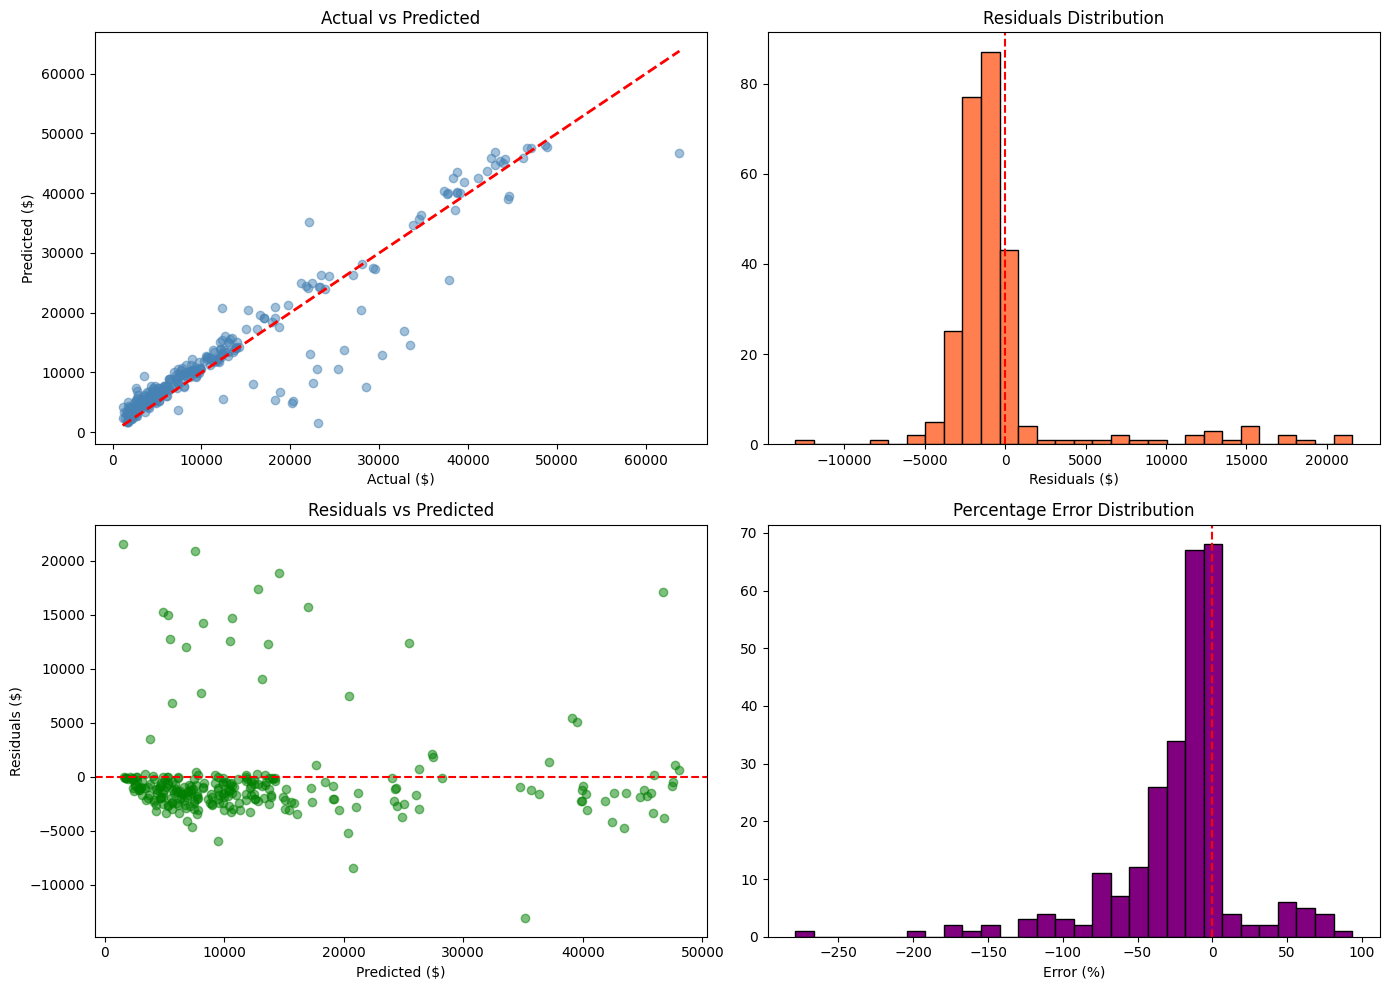

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error, max_error

y_pred = best_model.predict(X_test_raw)

r2 = r2_score(y_test_raw, y_pred)
mse = mean_squared_error(y_test_raw, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_raw, y_pred)
mape = mean_absolute_percentage_error(y_test_raw, y_pred) * 100

n, p = len(y_test_raw), X_test_raw.shape[1]
adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"R² Score: {r2:.4f}")
print(f"Adjusted R²: {adj_r2:.4f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print(f"MAPE: {mape:.2f}%")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

axes[0,0].scatter(y_test_raw, y_pred, alpha=0.5, color='steelblue')
axes[0,0].plot([y_test_raw.min(), y_test_raw.max()], [y_test_raw.min(), y_test_raw.max()], 'r--', lw=2)
axes[0,0].set_xlabel('Actual ($)'); axes[0,0].set_ylabel('Predicted ($)'); axes[0,0].set_title('Actual vs Predicted')

residuals = y_test_raw - y_pred
axes[0,1].hist(residuals, bins=30, color='coral', edgecolor='black')
axes[0,1].axvline(x=0, color='red', linestyle='--')
axes[0,1].set_xlabel('Residuals ($)'); axes[0,1].set_title('Residuals Distribution')

axes[1,0].scatter(y_pred, residuals, alpha=0.5, color='green')
axes[1,0].axhline(y=0, color='red', linestyle='--')
axes[1,0].set_xlabel('Predicted ($)'); axes[1,0].set_ylabel('Residuals ($)'); axes[1,0].set_title('Residuals vs Predicted')

pct_error = ((y_test_raw - y_pred) / y_test_raw) * 100
axes[1,1].hist(pct_error, bins=30, color='purple', edgecolor='black')
axes[1,1].axvline(x=0, color='red', linestyle='--')
axes[1,1].set_xlabel('Error (%)'); axes[1,1].set_title('Percentage Error Distribution')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: model_evaluation.png")

10. Web Interface with Gradio (10 Marks)

In [23]:
import gradio as gr
import joblib

model = joblib.load('best_insurance_model.pkl')

def predict_insurance_charges(age, sex, bmi, children, smoker, region):
    input_data = pd.DataFrame({
        'age': [age], 'sex': [sex], 'bmi': [bmi],
        'children': [children], 'smoker': [smoker], 'region': [region]
    })
    prediction = model.predict(input_data)[0]
    return f"**Predicted Insurance Charges:** ${prediction:,.2f}"

demo = gr.Interface(
    fn=predict_insurance_charges,
    inputs=[
        gr.Slider(minimum=18, maximum=100, value=30, step=1, label="Age"),
        gr.Radio(choices=["male", "female"], value="male", label="Sex"),
        gr.Slider(minimum=10, maximum=60, value=25, step=0.1, label="BMI"),
        gr.Slider(minimum=0, maximum=10, value=0, step=1, label="Children"),
        gr.Radio(choices=["yes", "no"], value="no", label="Smoker"),
        gr.Dropdown(choices=["northeast", "northwest", "southeast", "southwest"], value="northeast", label="Region")
    ],
    outputs=gr.Markdown(),
    title="Insurance Charges Predictor",
    description="Predict annual health insurance charges using Random Forest model.",
    examples=[[25, "male", 22.5, 0, "no", "northeast"], [45, "female", 28.0, 2, "no", "southwest"], [35, "male", 30.5, 1, "yes", "southeast"]]
)

demo.launch()

print("\nDeployed at: https://huggingface.co/spaces/komol23/insurance-predictor")

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.



Deployed at: https://huggingface.co/spaces/komol23/insurance-predictor


11. Deployment to Hugging Face (10 Marks)

In [24]:
app_py_content = '''import gradio as gr
import pandas as pd
import joblib

model = joblib.load('best_insurance_model.pkl')

def predict_insurance_charges(age, sex, bmi, children, smoker, region):
    input_data = pd.DataFrame({
        'age': [age], 'sex': [sex], 'bmi': [bmi],
        'children': [children], 'smoker': [smoker], 'region': [region]
    })
    prediction = model.predict(input_data)[0]
    return f"**Predicted Insurance Charges:** ${prediction:,.2f}"

demo = gr.Interface(
    fn=predict_insurance_charges,
    inputs=[
        gr.Slider(minimum=18, maximum=100, value=30, step=1, label="Age"),
        gr.Radio(choices=["male", "female"], value="male", label="Sex"),
        gr.Slider(minimum=10, maximum=60, value=25, step=0.1, label="BMI"),
        gr.Slider(minimum=0, maximum=10, value=0, step=1, label="Children"),
        gr.Radio(choices=["yes", "no"], value="no", label="Smoker"),
        gr.Dropdown(choices=["northeast", "northwest", "southeast", "southwest"], value="northeast", label="Region")
    ],
    outputs=gr.Markdown(),
    title="Insurance Charges Predictor",
    examples=[[25, "male", 22.5, 0, "no", "northeast"], [45, "female", 28.0, 2, "no", "southwest"]]
)

if __name__ == "__main__":
    demo.launch()
'''

with open('app.py', 'w') as f:
    f.write(app_py_content)

requirements_content = '''gradio==4.44.0
pandas==2.2.3
scikit-learn==1.5.2
joblib==1.4.2
numpy==2.0.2
'''

with open('requirements.txt', 'w') as f:
    f.write(requirements_content)

import os
print("Files for Hugging Face deployment:")
for f in ['app.py', 'requirements.txt', 'best_insurance_model.pkl']:
    if os.path.exists(f):
        print(f"  {f} ({os.path.getsize(f):,} bytes)")

print("\nSteps:")
print("1. Create account at huggingface.co")
print("2. Create new Space (Gradio SDK)")
print("3. Upload: app.py, requirements.txt, best_insurance_model.pkl")
print("4. Access at: https://huggingface.co/spaces/YOUR_USERNAME/YOUR_SPACE")

Files for Hugging Face deployment:
  app.py (1,258 bytes)
  requirements.txt (81 bytes)
  best_insurance_model.pkl (823,923 bytes)

Steps:
1. Create account at huggingface.co
2. Create new Space (Gradio SDK)
3. Upload: app.py, requirements.txt, best_insurance_model.pkl
4. Access at: https://huggingface.co/spaces/YOUR_USERNAME/YOUR_SPACE
